In [465]:
!pip install pgmpy
!pip install pandas
!pip install numpy
!pip install networkx[default]
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [466]:
import numpy as np
import pandas as pd
import missingno as mno
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.impute import SimpleImputer
from sklearn import metrics
from pgmpy.estimators import MaximumLikelihoodEstimator, TreeSearch, BayesianEstimator, PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel, BayesianNetwork, NaiveBayes
from pgmpy.inference import VariableElimination
from pgmpy.metrics import correlation_score, log_likelihood_score

### Load data

In [467]:
datafile = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data"

In [468]:
data = pd.read_csv(datafile)
# Preview the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   no-recurrence-events  285 non-null    object
 1   30-39                 285 non-null    object
 2   premeno               285 non-null    object
 3   30-34                 285 non-null    object
 4   0-2                   285 non-null    object
 5   no                    285 non-null    object
 6   3                     285 non-null    int64 
 7   left                  285 non-null    object
 8   left_low              285 non-null    object
 9   no.1                  285 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.4+ KB


## Data pre-processing
- Change the wrong data frame name

In [469]:
# Add column names
column_names = ['class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']
# Convert old column names back to data
data.append(list(data))
data.columns = column_names
data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
2,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
3,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
4,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no




*   Pre-process categorical data
*   Mark missing data as nan



In [470]:
replace_map = {'class': {'no-recurrence-events':0, 'recurrence-events':1},
               'age' : {'10-19':0, '20-29':1, '30-39':2, '40-49':3, '50-59':4, '60-69':5, '70-79':6, '80-89':7, '90-99':8},
               'menopause': {'lt40':0, 'ge40':1, 'premeno':2,},
               'tumor-size': {'0-4':0, '5-9':1, '10-14':2, '15-19':3, '20-24':4, '25-29':5, '30-34':6, '35-39':7, '40-44':8, '45-49':9, '50-54':10, '55-59':11},
               'inv-nodes': {'0-2':0, '3-5':1, '6-8':3, '9-11':4, '12-14':5, '15-17':6, '18-20':7, '21-23':8, '24-26':9, '27-29':10, '30-32':11, '33-35':12, '36-39':13},
               'node-caps': {'yes':1, 'no':0, '?':np.nan},
               'breast': {'left':0, 'right':1},
               'breast-quad': {'left_up':0, 'left_low':1, 'right_up':2, 'right_low':3, 'central':4, '?':np.nan},
               'irradiat': {'yes':1, 'no':0}}
data.replace(replace_map, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   class        285 non-null    int64  
 1   age          285 non-null    int64  
 2   menopause    285 non-null    int64  
 3   tumor-size   285 non-null    int64  
 4   inv-nodes    285 non-null    int64  
 5   node-caps    277 non-null    float64
 6   deg-malig    285 non-null    int64  
 7   breast       285 non-null    int64  
 8   breast-quad  284 non-null    float64
 9   irradiat     285 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 22.4 KB


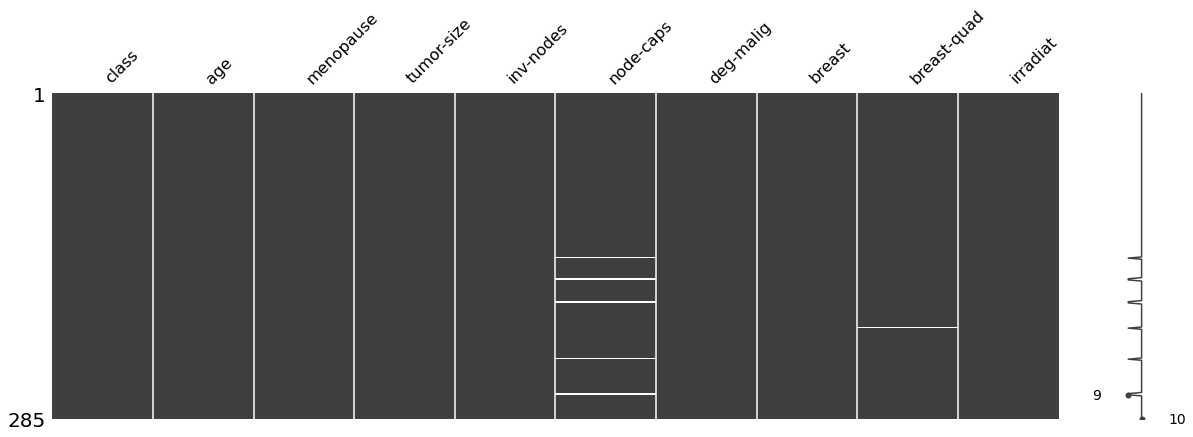

In [471]:
# Visualisation
mno.matrix(data, figsize = (20, 6))

### Missing data handling
Data imputation with most-frequent strategy

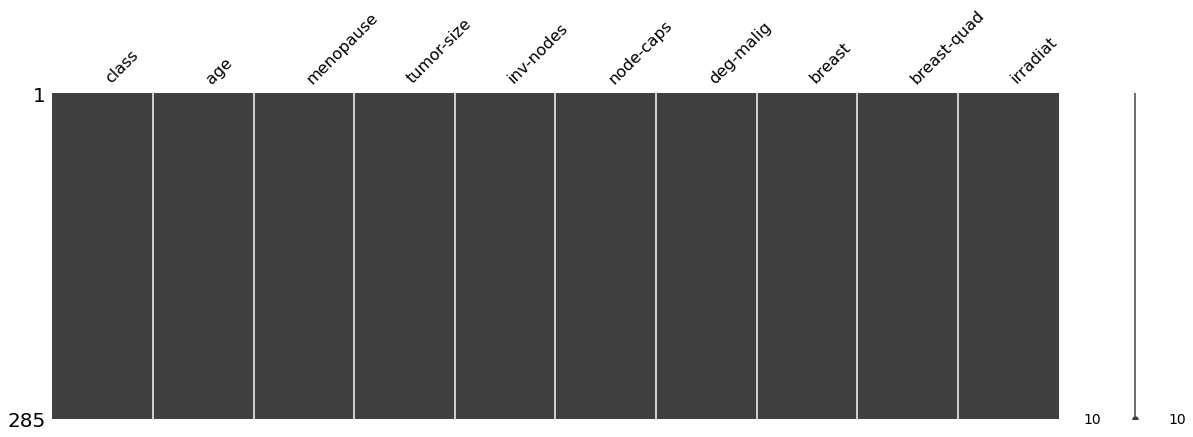

In [472]:
missing_columns = ['node-caps', 'breast-quad']
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(data[missing_columns])
data[missing_columns] = imp.transform(data[missing_columns])
mno.matrix(data, figsize = (20, 6))

### Split data into train and test sets

In [473]:
# Split data
train = data.sample(frac = 0.8, random_state = 1)
test = data.drop(train.index)

x_train = train.drop(columns = ['class'])
y_train = train['class']
x_test = test.drop(columns = ['class'])
y_test = test['class']

## 1. Naive Bayes model

In [474]:
# Naive Bayes model
# NB_model = NaiveBayes()
# NB_model.add_nodes_from(column_names)
NB_model = BayesianNetwork([('class', 'age'), ('class', 'menopause'), ('class', 'tumor-size'), ('class', 'inv-nodes'), ('class', 'node-caps'),
                          ('class', 'deg-malig'), ('class', 'breast'), ('class', 'breast-quad'), ('class', 'irradiat')])
NB_model.active_trail_nodes('class')

{'class': {'age',
  'breast',
  'breast-quad',
  'class',
  'deg-malig',
  'inv-nodes',
  'irradiat',
  'menopause',
  'node-caps',
  'tumor-size'}}

In [475]:
NB_model.fit(train, estimator=MaximumLikelihoodEstimator)
NB_model.get_cpds()

[<TabularCPD representing P(class:2) at 0x7fceea66a110>,
 <TabularCPD representing P(age:6 | class:2) at 0x7fceea1a3e50>,
 <TabularCPD representing P(menopause:3 | class:2) at 0x7fceee949a90>,
 <TabularCPD representing P(tumor-size:11 | class:2) at 0x7fcef2886c90>,
 <TabularCPD representing P(inv-nodes:7 | class:2) at 0x7fcef28dbc10>,
 <TabularCPD representing P(node-caps:2 | class:2) at 0x7fcef258e810>,
 <TabularCPD representing P(deg-malig:3 | class:2) at 0x7fceea59f190>,
 <TabularCPD representing P(breast:2 | class:2) at 0x7fcef28dbd90>,
 <TabularCPD representing P(breast-quad:5 | class:2) at 0x7fceebda7b90>,
 <TabularCPD representing P(irradiat:2 | class:2) at 0x7fceebe16650>]

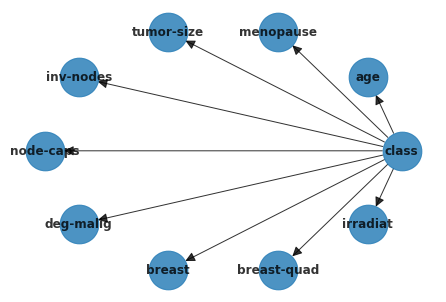

In [476]:
# Visualization
nx.draw_circular(NB_model, with_labels=True, arrowsize=20, node_size=1500, alpha=0.8, font_weight="bold")
plt.show()

### Testing

In [477]:
nb_pred = NB_model.predict(x_test)
# Model accuracy
nb_acc = metrics.accuracy_score(y_test, nb_pred)
print ("Naive Bayes' Accuracy:", nb_acc)

  0%|          | 0/54 [00:00<?, ?it/s]

Naive Bayes' Accuracy: 0.7192982456140351


## 2. Tree-structured Bayesian Network

Building tree:   0%|          | 0/45.0 [00:00<?, ?it/s]

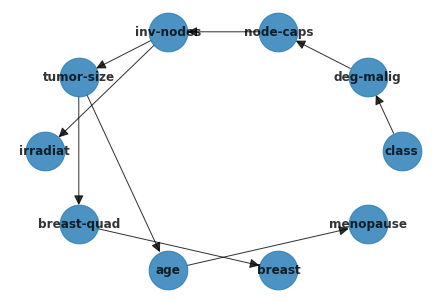

In [478]:
# learn graph structure
est = TreeSearch(train, root_node="class")
dag = est.estimate(estimator_type="chow-liu")

# there are many choices of parametrization, here is one example
TBN_model = BayesianNetwork(dag.edges())
TBN_model.fit(
    train, estimator=BayesianEstimator, prior_type="dirichlet", pseudo_counts=0.1
)
# TBN_model.get_cpds()
# Visualization
nx.draw_circular(TBN_model, with_labels=True, arrowsize=20, node_size=1500, alpha=0.8, font_weight="bold")
plt.show()

In [479]:
TBN_model.get_cpds()

[<TabularCPD representing P(class:2) at 0x7fceebda7110>,
 <TabularCPD representing P(deg-malig:3 | class:2) at 0x7fceeb57bfd0>,
 <TabularCPD representing P(node-caps:2 | deg-malig:3) at 0x7fceeb5f0350>,
 <TabularCPD representing P(inv-nodes:7 | node-caps:2) at 0x7fceea1f7f50>,
 <TabularCPD representing P(tumor-size:11 | inv-nodes:7) at 0x7fceeee3d510>,
 <TabularCPD representing P(irradiat:2 | inv-nodes:7) at 0x7fceebdcac10>,
 <TabularCPD representing P(breast-quad:5 | tumor-size:11) at 0x7fceeb6d0810>,
 <TabularCPD representing P(age:6 | tumor-size:11) at 0x7fceebdb66d0>,
 <TabularCPD representing P(breast:2 | breast-quad:5) at 0x7fcedcf16110>,
 <TabularCPD representing P(menopause:3 | age:6) at 0x7fcef258ead0>]

### Testing

In [480]:
tbn_pred = TBN_model.predict(x_test)
# Model accuracy
tbn_acc = metrics.accuracy_score(y_test, tbn_pred)
print ("Tree-structured Bayesian Network:", tbn_acc)

  0%|          | 0/54 [00:00<?, ?it/s]

Tree-structured Bayesian Network: 0.7192982456140351


## 3. Bayesian Network
### 3.1 Structure Learning

*   Score-Based approach: Using Hill Climb Search
*   Start with Naive Bayes DAG



  0%|          | 0/1000000 [00:00<?, ?it/s]

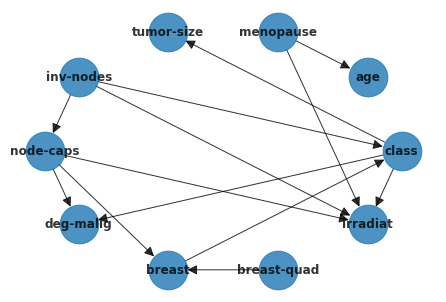

In [481]:
est = HillClimbSearch(train)
est_model = est.estimate(scoring_method=K2Score(train), start_dag=NB_model, fixed_edges={('class', 'tumor-size')})
BN_model = BayesianNetwork(est_model.edges())
# Visualization
nx.draw_circular(est_model, with_labels=True, arrowsize=20, node_size=1500, alpha=0.8, font_weight="bold")
plt.show()

### 3.2 Parameter Learning
Using Maximum Likelihood Estimation

In [482]:
BN_model.fit(train, estimator=MaximumLikelihoodEstimator)
BN_model.get_cpds()

[<TabularCPD representing P(class:2 | breast:2, inv-nodes:7) at 0x7fcef223e4d0>,
 <TabularCPD representing P(tumor-size:11 | class:2) at 0x7fcee79f7f90>,
 <TabularCPD representing P(deg-malig:3 | class:2, node-caps:2) at 0x7fcee79f7350>,
 <TabularCPD representing P(irradiat:2 | class:2, inv-nodes:7, menopause:3, node-caps:2) at 0x7fceea046710>,
 <TabularCPD representing P(menopause:3) at 0x7fcef2403a90>,
 <TabularCPD representing P(age:6 | menopause:3) at 0x7fcee707e390>,
 <TabularCPD representing P(inv-nodes:7) at 0x7fcee704ec10>,
 <TabularCPD representing P(node-caps:2 | inv-nodes:7) at 0x7fcee7035f50>,
 <TabularCPD representing P(breast:2 | breast-quad:5, node-caps:2) at 0x7fcee6db3750>,
 <TabularCPD representing P(breast-quad:5) at 0x7fceea1a3e10>]

### Testing

In [483]:
bn_pred = BN_model.predict(x_test)
# Model accuracy
bn_acc = metrics.accuracy_score(y_test, bn_pred)
print ("Bayesian Network:", bn_acc)

  0%|          | 0/54 [00:00<?, ?it/s]

Bayesian Network: 0.7017543859649122
